## Identification of patients admitted to hospital due to COVID-19 using emergence care attendance data

### Background
There is an urgent need to understand which patients are being admitted to hospital with COVID-19.  SUS-APCS data is the 'gold standard' for COVID-19 hospital admission but is only made available once the patient is discharged from hospital which can be many weeks or months after their admission.  Data for ongoing hospital spells at the time of the SUS-APCS extract is therefore not available, creating an ascertainment bias against longer spells and more recent spells. 

Hospital admission is a crucial outcome for vaccine evaluation.  The absence of rapidly available hospital admissions data means we cannot rapidly evaluate vaccine effectiveness with respect to reducing hospital admission, compare different vaccines' impact on hospital admission or identify changes in vaccine effectives on admission over time.

A large proportion of hospital admission comes through A&E attendance. Emergency admission data through ECDS is much more rapidly available than SUS-APCS.  We therefore set out to validate if those patients being admitted to hospital due to COVID-19 could be identified earlier using data made available through SUS-APCS.

### Methods

Working on behalf of NHS England we used routine clinical data from 24 million patients to conduct a retrospective cohort study of comprehensive electronic health record data in NHS England, using the OpenSAFELY-TPP platform which covers approximately 40% of the general population in England.  Using data between 2020-09-01 and 2021-01-01, we selected a study population that included all those that were registered with a GP practice at the start of the study period, were aged between 18-110 at the start of the study period, had not died before the start of the study period and those who had either attended emergency care or had been admitted to hospital at any point during the study period.  

Patients that were admitted to hospital with COVID-19 as their primary diagnosis were identified using a COVID-19 identification codelist made available at [OpenSAFELY Codelists here](https://codelists.opensafely.org/codelist/opensafely/covid-identification/2020-06-03/).  Patients that attended emergency care with COVID-19 were identified using the following SNOMED diagnosis code: 1240751000000100 and their discharge destination is extracted.  Patients attending emergency care with respiratory-related diagnosis codes were identified using the codelist available here ([upper resp infectio, lower resp infection, sars, pneumonia, resp failure]).Whether patients attending emergency care had had a positive COVID-19 test in the period inclusive of the 2 weeks prior to attendance and 1 weeks after attendance was also extracted, as was whether patients attending emergency care had had COVID-19 confirmed in primary care in the period 2 weeks prior to admission using the following [codelists]().

We first assessed how many patients hospitalised for any cause could be identified in those attending emergency care for any reason.  We then explore how many patients hospitalised for any cause could be identified in those attending emergency care who were discharged to either the ward or emergency short stay ward.  

We then look at identifying those admitted to hospital for COVID-19 in the emergency care data.  In the emergency care data, patients are defined as being admitted to hospital for COVID-19 if they attend emergency care and they have either had a recent positive COVID-19 test, have had recently confirmed COVID-19 in primary care, or are recorded as having a COVID-19 diagnosis code.  Using this classification we provide a contingency matrix and measures of measures of the predictive ability of identifying COVID-19 hospitalisations using emergency care data.  Variable importance of this classification is then assessed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import Markdown as md
from IPython.display import HTML, display
from collections import Counter
%matplotlib inline

pd.options.display.float_format = '{:.0f}'.format

In [2]:
df = pd.read_csv('../output/input.csv')
num_patients = len(df['patient_id'].unique())
num_patients_hosp = len(df[df['hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_prim_covid = len(df[df['primary_covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_covid = len(df[df['covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_positive_cov_test = len(df[(df['hospital_admission'].notna()) & (df['positive_covid_test_before_hospital_admission']==1)]['patient_id'].unique())
num_patients_hosp_positive_cov_pc = len(df[(df['hospital_admission'].notna()) & (df['covid_primary_care_before_hospital_admission']==1)]['patient_id'].unique())


num_patients_cov_hosp_attended_ae_any = len(df[(df['primary_covid_hospital_admission'].notna()) & (df['ae_attendance_any']==1)]['patient_id'].unique())
num_patients_cov_hosp_attended_ae = len(df[(df['primary_covid_hospital_admission'].notna()) & (df['ae_attendance']==1)]['patient_id'].unique())
num_patients_cov_hosp_attended_ae_covid = len(df[(df['primary_covid_hospital_admission'].notna()) & ((df['ae_attendance_any']==1)&(df['ae_attendance_covid_status']==1))]['patient_id'].unique())
num_patients_cov_hosp_attended_ae_pos_test = len(df[(df['primary_covid_hospital_admission'].notna()) & ((df['ae_attendance_any']==1)&(df['positive_covid_test_before_ae_attendance']==1))]['patient_id'].unique())
num_patients_cov_hosp_attended_ae_pos_test_month = len(df[(df['primary_covid_hospital_admission'].notna()) & ((df['ae_attendance_any']==1)&(df['positive_covid_test_month_before_ae_attendance']==1))]['patient_id'].unique())
num_patients_cov_hosp_attended_ae_pos_pc = len(df[(df['primary_covid_hospital_admission'].notna()) & ((df['ae_attendance_any']==1)&(df['covid_primary_care_before_ae_attendance']==1))]['patient_id'].unique())
num_patients_cov_hosp_attended_ae_resp = len(df[(df['primary_covid_hospital_admission'].notna()) & ((df['ae_attendance_any']==1)&(df['ae_attendance_respiratory_status']==1))]['patient_id'].unique())


num_patients_ae = len(df[df['ae_attendance_any']==1]['patient_id'].unique())
num_patients_ae_with_discharge_destination = len(df[(df['ae_attendance_any']==1) & df['discharge_destination'].notna()]['patient_id'].unique())
num_patients_ae_hosp_discharge = len(df[df['ae_attendance']==1]['patient_id'].unique())
num_patients_ae_pos_covid = len(df[(df['ae_attendance']==1) & (df['ae_attendance_covid_status']==1)]['patient_id'].unique())
num_patients_ae_pos_covid_test = len(df[(df['ae_attendance']==1) & (df['positive_covid_test_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_ae_pos_covid_pc = len(df[(df['ae_attendance']==1) & (df['covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())

### Results

In [3]:
md(f'Between 2020-09-01 and 2021-09-01 {num_patients} people out of 24 million in our dataset either attended emergency care ({num_patients_ae}) or were admitted to hospital ({num_patients_hosp}). In those admitted to hospital, {num_patients_hosp_covid} ({(num_patients_hosp_covid/num_patients_hosp)*100}%) were admitted with a COVID-19 diagnosis code.  {num_patients_hosp_prim_covid} ({(num_patients_hosp_prim_covid/num_patients_hosp)*100}) were admitted with a COVID-19 as their primary diagnosis code. In those attending emergency care, {num_patients_ae_with_discharge_destination} ({(num_patients_ae_with_discharge_destination/num_patients_ae)*100}%) had a recorded discharge destination.  A breakdown of discharge destination is shown below.')


Between 2020-09-01 and 2021-09-01 10000 people out of 24 million in our dataset either attended emergency care (4000) or were admitted to hospital (3000). In those admitted to hospital, 3000 (100.0%) were admitted with a COVID-19 diagnosis code.  3000 (100.0) were admitted with a COVID-19 as their primary diagnosis code. In those attending emergency care, 1571 (39.275%) had a recorded discharge destination.  A breakdown of discharge destination is shown below.

In [4]:
df['discharge_destination'] = df['discharge_destination'].astype('category')
not_null_dict = (Counter(df['discharge_destination'].notnull()))
destination_dict = (Counter(df[df['discharge_destination'].notnull()]['discharge_destination']))
missing_number = not_null_dict[False]
destination_dict['missing'] = missing_number

discharge_dict = {1066341000000100:"Ambulatory Emergency Care", 19712007: "Patient Transfer", 183919006: "Urgent admission to hospice", 1066361000000104: "High dependency unit", 305398007: "Mortuary", 1066381000000108: "Special baby care unit", 1066331000000109: "Emergency department short stay ward", 306705005: "Police custody", 306706006:"Ward", 306689006: "Home", 306694006: "Nursing Home", 306691003: "Residential Home", 1066351000000102: "Hospital at Home", 1066401000000108: "Neonatal ICU", 1066371000000106: "Coronary Care Unit", 50861005: "Legal Custody", 1066391000000105: "ICU", "missing": "missing"}

data = []
for key, value in destination_dict.items():
    row = [discharge_dict[key], value]
    data.append(row)

discharge_destination_df = pd.DataFrame(data, columns=["Discharge Destination", "%"])
discharge_destination_df



,Discharge Destination,%
0,ICU,1998
1,Ward,2002
2,missing,6000


In [5]:
md(f'In those who attended emergency care, {num_patients_ae_pos_covid} ({(num_patients_ae_pos_covid/num_patients_ae)*100:.2f}%) patients attended with COVID diagnosis code, {num_patients_ae_pos_covid_test} ({(num_patients_ae_pos_covid_test/num_patients_ae)*100:.2f}%) patients had had a positive COVID-19 in the 2 weeks prior to attendance and {num_patients_ae_pos_covid_pc} ({(num_patients_ae_pos_covid_pc/num_patients_ae)*100:.2f}%) patients had had COVID-19 confirmed in primary care in the weeks prior to attendance')



In those who attended emergency care, 3615 (90.38%) patients attended with COVID diagnosis code, 2013 (50.32%) patients had had a positive COVID-19 in the 2 weeks prior to attendance and 2015 (50.38%) patients had had COVID-19 confirmed in primary care in the weeks prior to attendance

In [6]:
md(f'In patients who were hospitalised with a primary diagnosis of COVID-19, {num_patients_cov_hosp_attended_ae_any} ({(num_patients_cov_hosp_attended_ae_any/num_patients_hosp_prim_covid)*100:.2f}%) attended emergency care.  Of these people, {num_patients_cov_hosp_attended_ae_covid} ({(num_patients_cov_hosp_attended_ae_covid/num_patients_hosp_prim_covid)*100:.2f}%) had a COVID-19 diagnosis code on attendance.  {num_patients_cov_hosp_attended_ae_resp} ({(num_patients_cov_hosp_attended_ae_resp/num_patients_hosp_prim_covid)*100:.2f}%) attended emergency care with respiratory related diagnosis codes.{num_patients_cov_hosp_attended_ae_pos_test} ({(num_patients_cov_hosp_attended_ae_pos_test/num_patients_hosp_prim_covid)*100:.2f}%) had had a positive COVID-19 test in the 2 weeks prior to attendance, and {num_patients_cov_hosp_attended_ae_pos_test_month} ({(num_patients_cov_hosp_attended_ae_pos_test_month/num_patients_hosp_prim_covid)*100:.2f}%) had had a positive test within the month prior to attendance.  {num_patients_cov_hosp_attended_ae_pos_pc} ({(num_patients_cov_hosp_attended_ae_pos_pc/num_patients_hosp_prim_covid)*100:.2f}%) of these patients had had COVID-19 confirmed in primary care in the 2 weeks prior to emergency attendance.')


In patients who were hospitalised with a primary diagnosis of COVID-19, 1212 (40.40%) attended emergency care.  Of these people, 1099 (36.63%) had a COVID-19 diagnosis code on attendance.  1099 (36.63%) attended emergency care with respiratory related diagnosis codes.600 (20.00%) had had a positive COVID-19 test in the 2 weeks prior to attendance, and 625 (20.83%) had had a positive test within the month prior to attendance.  614 (20.47%) of these patients had had COVID-19 confirmed in primary care in the 2 weeks prior to emergency attendance.

In [7]:

display(HTML(f'<table><tr><th>Group</th><th>Total</th><th>%</th></tr><tr><th>Hospital Admission</th></tr><tr><td>Admitted</td><td>{num_patients_hosp}</td><td>{(num_patients_hosp/num_patients_hosp)*100}</td></tr><tr><td>Admitted with primary COVID-19</td><td>{num_patients_hosp_prim_covid}</td><td>{(num_patients_hosp_prim_covid/num_patients_hosp)*100}</td></tr><tr><td>Admitted with COVID-19</td><td>{num_patients_hosp_covid}</td><td>{(num_patients_hosp_covid/num_patients_hosp)*100}</td></tr><tr><th>Emergence Care Attendance</th></tr><tr><td>Attended</td><td>{num_patients_ae}</td><td>{(num_patients_ae/num_patients_ae)*100}</td></tr><tr><td>Attendeded AE with discharge destination</td><td>{num_patients_ae_with_discharge_destination}</td><td>{(num_patients_ae_with_discharge_destination/num_patients_ae)*100}</td></tr><tr><td>Attended with COVID</td><td>{num_patients_ae_pos_covid}</td><td>{(num_patients_ae_pos_covid/num_patients_ae)*100}</td></tr><tr><td>Recent + COVID Test</td><td>{num_patients_ae_pos_covid_test}</td><td>{(num_patients_ae_pos_covid_test/num_patients_ae)*100}</td></tr><tr><td>Recent + COVID in Primary Care</td><td>{num_patients_ae_pos_covid_pc}</td><td>{(num_patients_ae_pos_covid_pc/num_patients_ae)*100}</td></tr><tr><th>Primary Covid Hospital Admission</th></tr><tr><td>Attended AE</td><td>{num_patients_cov_hosp_attended_ae_any}</td><td>{(num_patients_cov_hosp_attended_ae_any/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE with hospital discharge</td><td>{num_patients_cov_hosp_attended_ae}</td><td>{(num_patients_cov_hosp_attended_ae/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE COVID code</td><td>{num_patients_cov_hosp_attended_ae_covid}</td><td>{(num_patients_cov_hosp_attended_ae_covid/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE recent + test</td><td>{num_patients_cov_hosp_attended_ae_pos_test}</td><td>{(num_patients_cov_hosp_attended_ae_pos_test/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE + Covid Month</td><td>{num_patients_cov_hosp_attended_ae_pos_test_month}</td><td>{(num_patients_cov_hosp_attended_ae_pos_test_month/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE recent + PC</td><td>{num_patients_cov_hosp_attended_ae_pos_pc}</td><td>{(num_patients_cov_hosp_attended_ae_pos_pc/num_patients_hosp_prim_covid)*100}</td></tr><tr><td>Attended AE resp</td><td>{num_patients_cov_hosp_attended_ae_resp}</td><td>{(num_patients_cov_hosp_attended_ae_resp/num_patients_hosp_prim_covid)*100}</td></tr></table>'
            ))
    
    

In [8]:
positive_covid_patients_sus = df[df['primary_covid_hospital_admission'].notna()]
negative_covid_patients_sus = df[~df['primary_covid_hospital_admission'].notna()]

positive_covid_patients_ecds = df[(df['ae_attendance_any']==1) & ((df['ae_attendance_covid_status']==1) | (df['positive_covid_test_before_ae_attendance'] ==1) | (df['covid_primary_care_before_ae_attendance'] ==1) | (df['ae_attendance_respiratory_status']==1))]
negative_covid_patients_ecds = df[(df['ae_attendance_any']==0) | ((df['ae_attendance_any']==1) & ((df['ae_attendance_covid_status']==0) & (df['positive_covid_test_before_ae_attendance'] ==0) & (df['covid_primary_care_before_ae_attendance'] ==0) & (df['ae_attendance_respiratory_status']==0)))]


sus_patients_positive = set(list(positive_covid_patients_sus['patient_id']))
ecds_patients_positive = set(list(positive_covid_patients_ecds['patient_id']))

sus_patients_negative = set(list(negative_covid_patients_sus['patient_id']))
ecds_patients_negative = set(list(negative_covid_patients_ecds['patient_id']))


sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

The ability to predict COVID-19 hospitalisations using emergency care data is assessed
In those admitted to hospital as a result of COVID-19, how many could be identified by finding those that attended emergency care and had had either a previous positive covid test, had recently had covid confirmed in primary care, attended emergency care with a covid diagnosis code or attended emergency care with a respiratory code.

In [9]:
import statsmodels.api as sm 
import seaborn as sns

import matplotlib.pyplot as plt

# Create combo columns

df['ae_any_recent_positive_test'] = ((df['ae_attendance']==1) & (df['positive_covid_test_before_ae_attendance']==1) == True).astype(int)
df['ae_any_cov_code'] = ((df['ae_attendance']==1) & (df['ae_attendance_covid_status']==1) == True).astype(int)
df['ae_any_hosp_resp_code'] = ((df['ae_attendance']==1) & (df['ae_attendance_respiratory_status']==1) == True).astype(int)
df['ae_any_hosp_recent_pc'] = ((df['ae_attendance']==1) & (df['covid_primary_care_before_ae_attendance']==1) == True).astype(int)
df['y'] = (df['primary_covid_hospital_admission'].notna()).astype(int)



msk = np.random.rand(len(df)) < 0.8

train = df[msk]

test = df[~msk]

x_train = train[['ae_any_recent_positive_test', 'ae_any_cov_code', 'ae_any_hosp_resp_code', 'ae_any_hosp_recent_pc']]
x_test = test[['ae_any_recent_positive_test', 'ae_any_cov_code', 'ae_any_hosp_resp_code', 'ae_any_hosp_recent_pc']]
y_train = list(train['y'])
y_test = list(test['y'])


log_reg = sm.Logit(y_train, x_train).fit() 
print(log_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.667071
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7986
Model:                          Logit   Df Residuals:                     7982
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                -0.08934
Time:                        15:01:33   Log-Likelihood:                -5327.2
converged:                       True   LL-Null:                       -4890.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
ae_any_recent_positive_test    -0.1181      0.074     -1.599      0.110   

In [10]:
yhat = list(log_reg.predict(x_test))
prediction = list(map(round, yhat)) 

In [23]:
correct = 0
total = 0

pred_1_real_1 = 0
pred_1_real_0 = 0
pred_0_real_1 = 0
pred_0_real_0 = 0

for i, pred in enumerate(yhat):
    
    if pred == 1:
        if y_test[i] ==1:
            pred_1_real_1+=1
            correct+=1
        else:
            pred_1_real_0+=1
    
    else:
        if y_test[i] ==1:
            pred_0_real_1 +=1
        else:
            pred_0_real_0+=1
            correct+=1

    total+=1

cm = pd.DataFrame([[pred_0_real_0, pred_1_real_0], [pred_0_real_1, pred_1_real_1]], columns=["0", "1"], index=["0", "1"])
accuracy = (correct/total)*100
print(f'Accuracy = {accuracy:.2f}')

Accuracy = 70.71


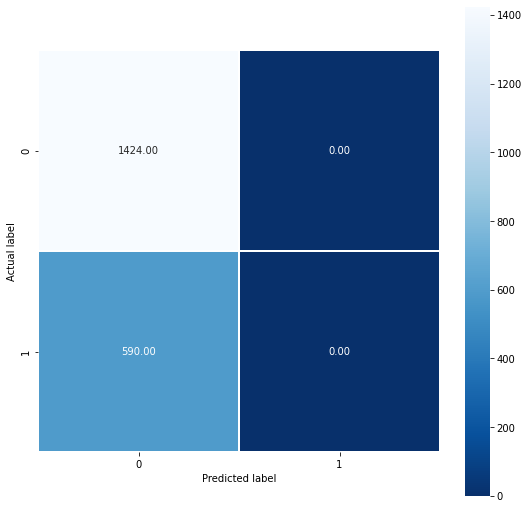

In [24]:

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["ECDS-positive", "ECDS-negative", "Total"])


In [ ]:

sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


In those admitted to hospital (any cause) how many could be identified looking at emergency care attendance (without appplying discharge filter).

In [5]:
positive_patients_sus = df[df['hospital_admission'].notna()]
negative_patients_sus = df[~df['hospital_admission'].notna()]

positive_patients_ecds = df[(df['ae_attendance_any']==1)]
negative_patients_ecds = df[(df['ae_attendance_any']==0)]

total_sus_patients_positive = set(list(positive_patients_sus['patient_id']))
total_sus_patients_negative = set(list(negative_patients_sus['patient_id']))


ecds_patients_positive = set(list(positive_patients_ecds['patient_id']))
ecds_patients_negative = set(list(negative_patients_ecds['patient_id']))

sus_total_pos_ecds_pos = len(list(set(total_sus_patients_positive) & set(ecds_patients_positive)))
sus_total_pos_ecds_neg = len(list(set(total_sus_patients_positive) & set(ecds_patients_negative)))
sus_total_neg_ecds_pos = len(list(set(total_sus_patients_negative) & set(ecds_patients_positive)))
sus_total_neg_ecds_neg = len(list(set(total_sus_patients_negative) & set(ecds_patients_negative)))

In [6]:
pd.DataFrame([[sus_total_pos_ecds_pos, sus_total_neg_ecds_pos, (sus_total_pos_ecds_pos + sus_total_neg_ecds_pos)], [sus_total_pos_ecds_neg, sus_total_neg_ecds_neg, (sus_total_pos_ecds_neg + sus_total_neg_ecds_neg)], [(sus_total_pos_ecds_pos+sus_total_pos_ecds_neg), (sus_total_neg_ecds_pos+sus_total_neg_ecds_neg), (sus_total_pos_ecds_pos + sus_total_pos_ecds_neg + sus_total_neg_ecds_pos + sus_total_neg_ecds_neg)]], columns=["SUS-total-positive", "SUS-total-negative", "Total"], index=["ECDS-positive", "ECDS-negative", "Total"])


,SUS-total-positive,SUS-total-negative,Total
ECDS-positive,1219,2781,4000
ECDS-negative,1781,4219,6000
Total,3000,7000,10000


In [7]:
#sensitivity - number of sus identified by ecds
#specificity - number of those not in sus who are not in ecds

sensitivity = (sus_total_pos_ecds_pos/(sus_total_pos_ecds_pos + sus_total_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_total_neg_ecds_neg/(sus_total_neg_ecds_pos + sus_total_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")

Sensitivity: 40.63%
Specificity : 60.27%


In those admitted to hospital (any cause) how many could be identified looking at emergency care attendance that results in discharge to ward or emergency short stay ward.

In [8]:
positive_patients_sus = df[df['hospital_admission'].notna()]
negative_patients_sus = df[~df['hospital_admission'].notna()]

positive_patients_ecds = df[(df['ae_attendance']==1)]
negative_patients_ecds = df[(df['ae_attendance']==0)]

total_sus_patients_positive = set(list(positive_patients_sus['patient_id']))
total_sus_patients_negative = set(list(negative_patients_sus['patient_id']))


ecds_patients_positive = set(list(positive_patients_ecds['patient_id']))
ecds_patients_negative = set(list(negative_patients_ecds['patient_id']))

sus_total_pos_ecds_pos = len(list(set(total_sus_patients_positive) & set(ecds_patients_positive)))
sus_total_pos_ecds_neg = len(list(set(total_sus_patients_positive) & set(ecds_patients_negative)))
sus_total_neg_ecds_pos = len(list(set(total_sus_patients_negative) & set(ecds_patients_positive)))
sus_total_neg_ecds_neg = len(list(set(total_sus_patients_negative) & set(ecds_patients_negative)))

In [9]:
pd.DataFrame([[sus_total_pos_ecds_pos, sus_total_neg_ecds_pos, (sus_total_pos_ecds_pos + sus_total_neg_ecds_pos)], [sus_total_pos_ecds_neg, sus_total_neg_ecds_neg, (sus_total_pos_ecds_neg + sus_total_neg_ecds_neg)], [(sus_total_pos_ecds_pos+sus_total_pos_ecds_neg), (sus_total_neg_ecds_pos+sus_total_neg_ecds_neg), (sus_total_pos_ecds_pos + sus_total_pos_ecds_neg + sus_total_neg_ecds_pos + sus_total_neg_ecds_neg)]], columns=["SUS-total-positive", "SUS-total-negative", "Total"], index=["ECDS-positive", "ECDS-negative", "Total"])


,SUS-total-positive,SUS-total-negative,Total
ECDS-positive,1180,2820,4000
ECDS-negative,1820,4180,6000
Total,3000,7000,10000


In [10]:
#sensitivity - number of sus identified by ecds
#specificity - number of those not in sus who are not in ecds

sensitivity = (sus_total_pos_ecds_pos/(sus_total_pos_ecds_pos + sus_total_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_total_neg_ecds_neg/(sus_total_neg_ecds_pos + sus_total_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")

Sensitivity: 39.33%
Specificity : 59.71%


In those admitted to hospital as a result of COVID-19, how many could be identified by finding those that attended emergency care, were later discharged to hospital and had had either a previous positive covid test, had recently had covid confirmed in primary care or attended emergency care with a covid diagnosis code.

In [11]:
positive_covid_patients_sus = df[df['primary_covid_hospital_admission'].notna()]
negative_covid_patients_sus = df[~df['primary_covid_hospital_admission'].notna()]

positive_covid_patients_ecds = df[(df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==1) | (df['positive_covid_test_before_ae_attendance'] ==1) | (df['covid_primary_care_before_ae_attendance'] ==1))]
negative_covid_patients_ecds = df[(df['ae_attendance']==0) | ((df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==0) & (df['positive_covid_test_before_ae_attendance'] ==0) & (df['covid_primary_care_before_ae_attendance'] ==0)))]


sus_patients_positive = set(list(positive_covid_patients_sus['patient_id']))
ecds_patients_positive = set(list(positive_covid_patients_ecds['patient_id']))

sus_patients_negative = set(list(negative_covid_patients_sus['patient_id']))
ecds_patients_negative = set(list(negative_covid_patients_ecds['patient_id']))


sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

In [12]:
pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["ECDS-positive", "ECDS-negative", "Total"])


,SUS-positive,SUS-negative,Total
ECDS-positive,1193,2697,3890
ECDS-negative,1807,4303,6110
Total,3000,7000,10000


In [13]:
#sensitivity - number of sus identified by ecds
#specificity - number of those not in sus who are not in ecds

sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


Sensitivity: 39.77%
Specificity : 61.47%


## Variable Breakdown 

### AE Attendance (and subsequent discharge to ward or icu)


In [14]:
positive_ae_covid_ecds = df[((df['ae_attendance']==1))]
negative_ae_covid_ecds = df[((df['ae_attendance']==0))]


ecds_patients_positive = set(list(positive_ae_covid_ecds['patient_id']))
ecds_patients_negative = set(list(negative_ae_covid_ecds['patient_id']))

sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["AE attendance +", "AE attendance -", "Total"])


,SUS-positive,SUS-negative,Total
AE attendance +,1218,2782,4000
AE attendance -,1782,4218,6000
Total,3000,7000,10000


In [15]:
sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


Sensitivity: 40.60%
Specificity : 60.26%


### AE Attendance + AE Covid Status

In [16]:
positive_ae_covid_ecds = df[(df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==1))]
negative_ae_covid_ecds = df[((df['ae_attendance']==0) | ((df['ae_attendance']==1) & (df['ae_attendance_covid_status']==0)))]



ecds_patients_positive = set(list(positive_ae_covid_ecds['patient_id']))
ecds_patients_negative = set(list(negative_ae_covid_ecds['patient_id']))

sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["AE Covid +", "AE Covid -", "Total"])



,SUS-positive,SUS-negative,Total
AE Covid +,1095,2483,3578
AE Covid -,1905,4517,6422
Total,3000,7000,10000


In [17]:
sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


Sensitivity: 36.50%
Specificity : 64.53%


###  AE Attendance + Recent Positive Covid Test

In [18]:
positive_cov_test_ecds = df[(df['ae_attendance']==1) & ((df['positive_covid_test_before_ae_attendance']==1))]
negative_cov_test_ecds = df[((df['ae_attendance']==0) | ((df['ae_attendance']==1) & (df['positive_covid_test_before_ae_attendance']==0)))]


ecds_patients_positive = set(list(positive_cov_test_ecds['patient_id']))
ecds_patients_negative = set(list(negative_cov_test_ecds['patient_id']))

sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["Covid Test +", "Covid Test -", "Total"])


,SUS-positive,SUS-negative,Total
Covid Test +,633,1417,2050
Covid Test -,2367,5583,7950
Total,3000,7000,10000


In [19]:
sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


Sensitivity: 21.10%
Specificity : 79.76%


### AE Attendance + Covid Positive Primary Care

In [20]:
positive_cov_pc_ecds = df[(df['ae_attendance']==1) & ((df['covid_primary_care_before_ae_attendance']==1))]
negative_cov_pc_ecds = df[((df['ae_attendance']==0) | ((df['ae_attendance']==1) & (df['covid_primary_care_before_ae_attendance']==0)))]


ecds_patients_positive = set(list(positive_cov_pc_ecds['patient_id']))
ecds_patients_negative = set(list(negative_cov_pc_ecds['patient_id']))

sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(ecds_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(ecds_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(ecds_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(ecds_patients_negative)))

pd.DataFrame([[sus_pos_ecds_pos, sus_neg_ecds_pos, (sus_pos_ecds_pos + sus_neg_ecds_pos)], [sus_pos_ecds_neg, sus_neg_ecds_neg, (sus_pos_ecds_neg + sus_neg_ecds_neg)], [(sus_pos_ecds_pos+sus_pos_ecds_neg), (sus_neg_ecds_pos+sus_neg_ecds_neg), (sus_pos_ecds_pos + sus_pos_ecds_neg + sus_neg_ecds_pos + sus_neg_ecds_neg)]], columns=["SUS-positive", "SUS-negative", "Total"], index=["Primary Care Covid +", "Primary Care Covid -", "Total"])


,SUS-positive,SUS-negative,Total
Primary Care Covid +,612,1399,2011
Primary Care Covid -,2388,5601,7989
Total,3000,7000,10000


In [21]:
sensitivity = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
print(f"Sensitivity: {sensitivity:.2f}%")

specificity = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
print(f"Specificity : {specificity:.2f}%")


Sensitivity: 20.40%
Specificity : 80.01%
